In [1]:
from utils import gpu_cpu_test
gpu_cpu_test()
#checking gpu|cpu computation abilities

TF version - 1.8.0
Default GPU Device: /device:GPU:0
---------- -----------
Using device info: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15364843434981437178
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3225105203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1817406508381914450
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from dataset_getter import open_dataset
from utils import save_history

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K
import easygui

Using TensorFlow backend.


In [3]:
#load and prepare data
ecg_segment_len = 252
n_channels=12
x_train, x_test, _, _ = open_dataset()
x_train = np.swapaxes(x_train, 1, 3)
x_test = np.swapaxes(x_test, 1, 3)
x_train = x_train[:, 0:ecg_segment_len, :, : ]
x_test = x_test[:, 0:ecg_segment_len, :, :]
print("после свопа со срезом x_test - " + str(x_test.shape))
print("после свопа со срезом x_train - " + str(x_train.shape))
#slice 5000 -> 252

загружаем 2д-датасет из файла C:\Users\milom\YandexDisk\Documents\Programming\Projects\Python\Deep Learning\DL_ECG\all_datasets_here\ELECTRIC_AXIS.pkl
409  записей 
y_train  имеет форму (274, 5)
x_train  имеет форму (274, 12, 1, 5000)
x_test   имеет форму (135, 12, 1, 5000)
y_test   имеет форму (135, 5)
после свопа со срезом x_test - (135, 252, 1, 12)
после свопа со срезом x_train - (274, 252, 1, 12)


In [4]:
#input ecg
input_data=Input(shape=(ecg_segment_len, 1, n_channels))

In [31]:
#convolitonal layers
x=Convolution2D(10,kernel_size=(5,1),strides=(1,1), activation='linear',padding='same')(input_data)
encoded=MaxPooling2D((2,1), padding='same')(x)

In [35]:
#deconvolutional layers
x=Convolution2D(12,kernel_size=(3,1),strides=(1,1),activation='linear',padding='same')(encoded)
decoded=UpSampling2D((2,1))(x)

In [36]:
caterpillar=Model(input_data,decoded)
caterpillar.summary()
caterpillar.compile(optimizer='nadam',loss='mean_squared_logarithmic_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 252, 1, 12)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 252, 1, 10)        610       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 126, 1, 10)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 126, 1, 12)        372       
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 252, 1, 12)        0         
Total params: 982
Trainable params: 982
Non-trainable params: 0
_________________________________________________________________


In [37]:
train_history=caterpillar.fit(x_train,x_train, epochs=50,batch_size=20,validation_data=(x_test,x_test),callbacks=None)

Train on 274 samples, validate on 135 samples
Epoch 1/50
274/274 [==============================] - 1s 4ms/step - loss: 3.8781 - val_loss: 2.9414
Epoch 2/50
274/274 [==============================] - 0s 342us/step - loss: 2.2419 - val_loss: 1.7647
Epoch 3/50
274/274 [==============================] - 0s 313us/step - loss: 1.3971 - val_loss: 1.2041
Epoch 4/50
274/274 [==============================] - 0s 302us/step - loss: 0.9470 - val_loss: 0.8980
Epoch 5/50
274/274 [==============================] - 0s 306us/step - loss: 0.6987 - val_loss: 0.6800
Epoch 6/50
274/274 [==============================] - 0s 306us/step - loss: 0.5260 - val_loss: 0.5309
Epoch 7/50
274/274 [==============================] - 0s 317us/step - loss: 0.4015 - val_loss: 0.4524
Epoch 8/50
274/274 [==============================] - 0s 324us/step - loss: 0.3400 - val_loss: 0.3851
Epoch 9/50
274/274 [==============================] - 0s 309us/step - loss: 0.2945 - val_loss: 0.3366
Epoch 10/50
274/274 [=================

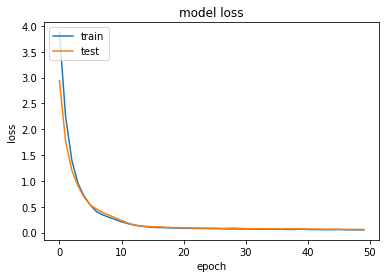

In [38]:
save_history(train_history,'toy')
model_name='ae_'
caterpillar.save(model_name+'toy.h5')
caterpillar.save_weights(model_name+'toy_weights.h5')

In [39]:
#Visualization test
def show_reconstruction_by_ae(ecg_sample, name):
    filepath = easygui.fileopenbox("выберите файл с обученной моделью .h5")
    trained_model = load_model(filepath)

    ecg_sample = np.array([ecg_sample])
    prediction = trained_model.predict(ecg_sample)

    draw_reconstruction_to_png(ecg_sample[0],prediction[0], name)

def get_ecg_test_sample(num_patient):
    sample = x_test[num_patient,:,:,:]
    print("форма тензора с экг: "+ str(sample.shape))
    return sample

def draw_reconstruction_to_png(ecg_true, ecg_predicted, png_filename):
    """
    :param ecg_true: истинная экг
    :param ecg_predicted: предсказанное
    :param png_filename: имя для файла с картинкой
    :return:
    """
    ecg_true = reshape_ecg_tensor(ecg_true)
    ecg_predicted = reshape_ecg_tensor(ecg_predicted)

    assert ecg_true.shape == ecg_predicted.shape

    len_of_time = len(ecg_true[0])
    t = [i for i in range(len_of_time)]


    rows = len(ecg_true)  # кол-во каналов
    cols = 2              # true и predicted - 2 столбика
    f, axarr = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for i in range(rows):
        true_i_chanel = ecg_true[i]
        predicted_i_chanel = ecg_predicted[i]
        axarr[i, 0].plot(t, true_i_chanel)
        axarr[i, 1].plot(t, predicted_i_chanel)


    plt.savefig(png_filename+".png")

def reshape_ecg_tensor(ecg):
    # превратим (252, 1, 12) в (12, 252)
    print ("форма тезора с экг =  " + str(ecg.shape))
    ecg = ecg[:,0,:]
    ecg = np.transpose(ecg)
    print ("форма тезора с экг (после напильника) =" + str(ecg))
    return ecg

форма тензора с экг: (252, 1, 12)
форма тезора с экг =  (252, 1, 12)
форма тезора с экг (после напильника) =[[ -6.02731365  -5.87472343  -5.87472343 ...  -6.02731365  -5.87472343
   -5.87472343]
 [-18.23453117 -18.08194095 -18.08194095 ... -27.23735409 -27.23735409
  -27.23735409]
 [-12.13092241 -12.13092241 -12.13092241 ... -21.13374533 -21.28633555
  -21.28633555]
 ...
 [  3.12809949   3.12809949   3.12809949 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-24.33813993 -24.18554971 -24.18554971 ... -15.03013657 -15.03013657
  -15.03013657]
 [-30.44174868 -30.28915846 -30.28915846 ... -15.03013657 -15.03013657
  -15.03013657]]
форма тезора с экг =  (252, 1, 12)
форма тезора с экг (после напильника) =[[ -7.280253    -7.280253    -6.2397265  ...  -7.814229     0.47274697
    0.47274697]
 [-11.196496   -11.196496   -20.188442   ... -27.248621   -13.368406
  -13.368406  ]
 [ -3.2349102   -3.2349102  -10.963903   ... -22.586815   -10.629578
  -10.629578  ]
 ...
 [  7.568306     7.568306   

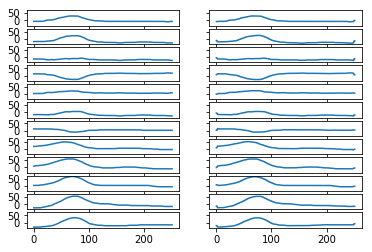

In [40]:
name = "merkel"
#model = train_canterpillar(name)
ecg_sample = get_ecg_test_sample(num_patient=0)
show_reconstruction_by_ae(ecg_sample, name)